<a href="https://colab.research.google.com/github/fvicencioh/FEM/blob/main/Tarea%205/Tarea_5_FEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de dependencias

In [10]:
!pip install --upgrade meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 9.0 MB/s eta 0:00:00


# Desarrollo de la tarea 5

In [12]:
import meshio
import numpy as np
import time
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata, interp1d, LinearNDInterpolator
from matplotlib.collections import PolyCollection

class system_2D:
  def __init__(self, mesh, E_m, nu, factor, mode='plane_strain'):
    if mode != 'plane_strain' and mode != 'plane_stress':
      raise ValueError(f'No se reconoce el modo {mode}')
    else:
      self.mode = mode
    self.factor = factor
    #---------- Lectura de datos -------------#
    self.mesh = meshio.read(mesh)
    self.nodes = self.mesh.points
    self.triangles = self.mesh.cells_dict['triangle6']
    self.lines = self.mesh.cells_dict['line3']
    self.n_nodes = len(self.nodes)
    self.n_triangles = len(self.triangles)
    self.n_lines = len(self.lines)

    #---------- Definición de constantes físicas -------------#
    self.E_m = E_m
    self.nu_m = nu
    self.E_i = E_m * factor
    self.nu_i = nu

    self.lam_m = (self.E_m*self.nu_m)/( (1+self.nu_m)*(1-2*self.nu_m) ) # Lambda
    self.mu_m = self.E_m/(2*(1+self.nu_m)); # Mu
    self.lam_i = (self.E_i*self.nu_i)/( (1+self.nu_i)*(1-2*self.nu_i) )
    self.mu_i = self.E_i/(2*(1+self.nu_i));
    if mode == 'plane_stress':
      self.lam_m = (2*self.mu_m*self.lam_m)/(self.lam_m + 2*self.mu_m)
      self.lam_i = (2*self.mu_i*self.lam_i)/(self.lam_i + 2*self.mu_i)

    #----------- Definición de matriz constitutiva -----------#
    if mode == 'plane_stress':
      self.C_m = (self.E_m/(1-self.nu_m**2)) * np.array([[1, self.nu_m, 0],[self.nu_m, 1, 0],[0, 0, (1-self.nu_m)/2]])
      self.C_i = (self.E_i/(1-self.nu_i**2)) * np.array([[1, self.nu_i, 0],[self.nu_i, 1, 0],[0, 0, (1-self.nu_i)/2]])
    elif mode == 'plane_strain':
      self.C_m = (self.E_m/((1+self.nu_m)*(1-2*self.nu_m))) * np.array([[1-self.nu_m, self.nu_m, 0],[self.nu_m, 1-self.nu_m, 0],[0, 0, (1-2*self.nu_m)/2]])
      self.C_i = (self.E_i/((1+self.nu_i)*(1-2*self.nu_i))) * np.array([[1-self.nu_i, self.nu_i, 0],[self.nu_i, 1-self.nu_i, 0],[0, 0, (1-2*self.nu_i)/2]])

    #---------- Salida de datos -------------#
    print('Mesh imported correctly')
    print(f'Number of nodes: {self.n_nodes}.')
    print(f'Number of elements: {self.n_triangles}.')

  #----------------- Resuelve el sistema lineal -----------------#

  def solve_system(self, sigma_o=1500e3, solver='numpy'):
    print(f'Resolviendo bajo un modelo de "{self.mode}"')

    t0 = time.perf_counter()

    # --- Etapa 1: Grupos físicos ---
    t = time.perf_counter()
    self.define_physical_groups()
    print(f'  [1/6] Identificar grupos físicos        -> {time.perf_counter() - t:8.4f} s')

    # --- Etapa 2: Límites geométricos ---
    t = time.perf_counter()
    self.set_limits()
    print(f'  [2/6] Fijar límites del dominio         -> {time.perf_counter() - t:8.4f} s')

    # --- Etapa 3: Ensamblaje K global ---
    t = time.perf_counter()
    self.assemble_K_general()
    print(f'  [3/6] Ensamblaje de matriz de rigidez   -> {time.perf_counter() - t:8.4f} s')

    # --- Etapa 4: RHS (cargas + BCs) ---
    t = time.perf_counter()
    self.set_rhs(sigma_o=sigma_o)
    print(f'  [4/6] Ensamblaje de vector de tracción  -> {time.perf_counter() - t:8.4f} s')

    # --- Etapa 5: Solución del sistema lineal ---
    print('Resolviendo sistema lineal ...')
    t = time.perf_counter()
    if solver == 'numpy':
      self.U = np.linalg.solve(self.Kg, self.FV)
      print(f'  [5/6] Resolución de sistema lineal      -> {time.perf_counter() - t:8.4f} s')

    elif solver == 'GMRES':
      A = sp.csr_matrix(self.Kg)
      b = self.FV
      #------- Precondicionador de Jacobi para mejorar tiempos
      diag = A.diagonal()
      diag_safe = np.where(np.abs(diag) > 0, diag, 1.0)
      M_inv = sp.diags(1.0 / diag_safe)
      M = spla.aslinearoperator(M_inv)
      it_history = []

      def cb_pr_norm(resid):
        it_history.append(resid)
        #print(f'    iter {len(it_history):4d}: residual = {resid:.3e}')

      try:
        U, info = spla.gmres(A, b, M=M, rtol=1e-5, atol=0.0,
                              maxiter=None, callback=cb_pr_norm,
                              callback_type='pr_norm')
      except TypeError:
        def cb_vec(xk):
          resid = np.linalg.norm(b - A.dot(xk))
          it_history.append(resid)
          #print(f'    iter {len(it_history):4d}: residual = {resid:.3e}')

        U, info = spla.gmres(A, b, M=M, rtol=1e-5, atol=0.0,
                              maxiter=None, callback=cb_vec)

      self.U = U
      print(f'  [5/6] Resolución de sistema lioneal (gmres) -> {time.perf_counter() - t:8.4f} s')
      final_resid = np.linalg.norm(b - A.dot(self.U))
      if info == 0:
        print(f'    GMRES convergió. Residual final (||b - A u||) = {final_resid:.3e}')
      else:
        print(f'    GMRES NO convergió (info={info}). Residual final = {final_resid:.3e}')

    else:
      raise NotImplementedError(f'Solver "{solver}" no implementado.')

    self.ux = self.U[::2]
    self.uy = self.U[1::2]


    # --- Etapa 6: Post-proceso (strain/stress + mapeo nodal + von misses) ---
    t = time.perf_counter()
    self.compute_strain_stress()
    self.map_strain_stress_to_nodes()
    self.compute_von_misses()
    print(f'  [6/6] Cálculo de esfuerzo y deformación  -> {time.perf_counter() - t:8.4f} s')

    # --- Resumen total ---
    print(f'  [Total]                                  -> {time.perf_counter() - t0:8.4f} s')


  #----------------- Separar los elementos entre el medio y la inclusión -----------------#
  #----------------- Identifica las lineas que forman el contorno -----------------#
  def define_physical_groups(self):

    for cb, phys in zip(self.mesh.cells, self.mesh.cell_data["gmsh:physical"]):
      if cb.type == 'triangle6':

        if phys[0] == 8:
          self.triangles_m = cb.data # Elementos del medio
        elif phys[0] == 9:
          self.triangles_i = cb.data # Elementos de la inclusión
      elif cb.type == 'line3':

        if phys[0] == 1:
          self.lines_r = cb.data # Lineas del lado derecho
        elif phys[0] == 2:
          self.lines_t = cb.data # Lineas superiores
        elif phys[0] == 3:
          self.lines_l = cb.data # Lineas del lado izquierdo
        elif phys[0] == 4:
          self.lines_e = cb.data # Lineas del límite, arco de elipse
        elif phys[0] == 5:
          self.lines_b = cb.data # Lineas inferiores
        elif phys[0] == 6:
          self.lines_eb = cb.data # Lineas inferiores, dentro de la elipse
        elif phys[0] == 7:
          self.lines_el = cb.data # Lineas del lado izquierdo, dentro de la elipse

    self.n_triangles_m = len(self.triangles_m)
    self.n_triangles_i = len(self.triangles_i)
    self.n_lines_r = len(self.lines_r)
    self.n_lines_t = len(self.lines_t)
    self.n_lines_l = len(self.lines_l)
    self.n_lines_e = len(self.lines_e)
    self.n_lines_b = len(self.lines_b)
    self.n_lines_eb = len(self.lines_eb)
    self.n_lines_el = len(self.lines_el)

  #----------------- Ensamblaje de matriz de rigidez elemental -----------------#

  def compute_Ke(self, element_number, D):

    coords = self.nodes[self.triangles[element_number], :2]

    gauss_point = np.array([[1/6, 1/6],
                            [2/3, 1/6],
                            [1/6, 2/3]])

    weights = np.array([1/3, 1/3, 1/3])

    Ke = np.zeros((12,12))

    for (z1, z2), w in zip(gauss_point, weights):

      dN_dz1, dN_dz2 = self.shape_functions_derivatives(z1, z2)

      JAC = self.compute_Jacobian(coords, dN_dz1, dN_dz2)
      DET_JAC = np.linalg.det(JAC)
      INV_JAC = np.linalg.inv(JAC)

      dN_dxdy = np.vstack([dN_dz1, dN_dz2]).T @ INV_JAC

      B = np.zeros((3, 12))
      for i in range(6):
        B[0, 2*i]     = dN_dxdy[i, 0]
        B[1, 2*i+1]   = dN_dxdy[i, 1]
        B[2, 2*i]     = dN_dxdy[i, 1]
        B[2, 2*i+1]   = dN_dxdy[i, 0]

      Ke+= B.T @ D @ B * DET_JAC * w

    return Ke

  #---------- Ensamblaje de matriz general de rigidez -------------#

  def assemble_K_general(self):

    dof = 2

    self.Kg = np.zeros((dof*self.n_nodes, dof*self.n_nodes))

    for i in self.triangles_m: # iteración sobre los elementos del medio
      index = np.where((self.triangles == i).all(axis=1))[0][0]
      Ke = self.compute_Ke(index, self.C_m)

      p1, p2, p3, p4, p5, p6 = i

      IV = np.array([dof*p1, dof*p1+1, dof*p2, dof*p2+1, dof*p3, dof*p3+1, dof*p4, dof*p4+1, dof*p5, dof*p5+1, dof*p6, dof*p6+1])

      for j in range(len(IV)):
        self.Kg[IV[j], IV]+= Ke[j, :]

    for i in self.triangles_i: # iteración sobre los elementos de la inclusión
      index = np.where((self.triangles == i).all(axis=1))[0][0]
      Ke = self.compute_Ke(index, self.C_i)

      p1, p2, p3, p4, p5, p6 = i

      IV = np.array([dof*p1, dof*p1+1, dof*p2, dof*p2+1, dof*p3, dof*p3+1, dof*p4, dof*p4+1, dof*p5, dof*p5+1, dof*p6, dof*p6+1])

      for j in range(len(IV)):
        self.Kg[IV[j], IV]+= Ke[j,:]

  #------------------- Ensamblaje del lado derecho de la ecuación -----------------------#
  def set_rhs(self, sigma_o = 1500e3):
    dof = 2 # Cada nodo tiene un desplazamiento ux y uy
    self.FV = np.zeros(dof*self.n_nodes)
    #------------------- Fijar condición de simetría -----------------------#
    # ux es 0 es los nodos del lado izquierdo
    # uy es 0 en los nodos del borde inferior
    # Por consecuencia, el centro de la elipse queda como un punto fijo
    #------------------- Lado Izquierdo -----------------------#
    for line in np.concatenate((self.lines_l, self.lines_el)):
      for node in line:
        self.Kg[dof*node, :] = 0.0
        self.Kg[:, dof*node] = 0.0
        self.Kg[dof*node, dof*node] = 1.0
    #------------------- Lado Inferior -----------------------#
    for line in np.concatenate((self.lines_b, self.lines_eb)):
      for node in line:
        self.Kg[dof*node+1, :] = 0.0
        self.Kg[:, dof*node+1] = 0.0
        self.Kg[dof*node+1, dof*node+1] = 1.0
    #------------------- Aplicación de tracción superficial -----------------------#
    gauss_pts = np.array([-np.sqrt(3/5), 0.0, np.sqrt(3/5)])
    gauss_wts = np.array([5/9, 8/9, 5/9])

    for line in self.lines_t:
      p1, p2, p3 = line # Meshio entrega las linead como [inicio, final, mitad]

      x1, y1 = self.nodes[p1][:2]
      x2, y2 = self.nodes[p2][:2]
      x3, y3 = self.nodes[p3][:2]

      Fe_line = np.zeros(3)

      for z, w in zip(gauss_pts, gauss_wts):

        N1 = 0.5 * z * (z - 1)
        N2 = 0.5 * z * (z + 1)
        N3 = (1 - z**2)

        SLV = np.array([N1, N2, N3])

        dN1_dz = z - 0.5
        dN2_dz = z + 0.5
        dN3_dz = -2*z

        dx_dz = dN1_dz*x1 + dN2_dz*x2 + dN3_dz*x3
        dy_dz = dN1_dz*y1 + dN2_dz*y2 + dN3_dz*y3

        JAC = np.sqrt(dx_dz**2 + dy_dz**2)

        Fe_line+= sigma_o * w * JAC * SLV

      self.FV[dof*p1 + 1]+= Fe_line[0]
      self.FV[dof*p2 + 1]+= Fe_line[1]
      self.FV[dof*p3 + 1]+= Fe_line[2]

  def set_limits(self):
    #-------------- Límites generales del dominio --------------#
    self.x_max = np.max(self.nodes[:,0])
    self.x_min = np.min(self.nodes[:,0])
    self.y_max = np.max(self.nodes[:,1])
    self.y_min = np.min(self.nodes[:,1])
    self.x_cen = (self.x_max + self.x_min)/2
    self.y_cen = (self.y_max + self.y_min)/2
    self.x_length = self.x_max - self.x_min
    self.y_length = self.y_max - self.y_min

    #-------------- Límites de la elipse --------------#
    ellipse_coords = self.nodes[self.triangles_i,:2].reshape(6*self.n_triangles_i, 2) # Por los 6 nodos x triangulo
    self.xe_max = np.max(ellipse_coords[:,0])
    self.xe_min = np.min(ellipse_coords[:,0])
    self.ye_max = np.max(ellipse_coords[:,1])
    self.ye_min = np.min(ellipse_coords[:,1])

  #------------------- Definición de funciones de forma -------------------#
  def shape_functions(self, z1, z2):
    z3 = 1 - z1 - z2

    N1 = z1*(2*z1 - 1)
    N2 = z2*(2*z2 - 1)
    N3 = z3*(2*z3 - 1)
    N4 = 4*z1*z2
    N5 = 4*z2*z3
    N6 = 4*z3*z1

    return np.array([N1, N2, N3, N4, N5, N6])

  #------------------- Derivada de las funciones de forma -------------------#
  def shape_functions_derivatives(self, z1, z2):
    z3 = 1 - z1 - z2

    dN1_dz1 = 4*z1 - 1
    dN2_dz1 = 0
    dN3_dz1 = -4*z3 + 1
    dN4_dz1 = 4*z2
    dN5_dz1 = -4*z2
    dN6_dz1 = 4*(z3 - z1)

    dN1_dz2 = 0
    dN2_dz2 = 4*z2 - 1
    dN3_dz2 = -4*z3 + 1
    dN4_dz2 = 4*z1
    dN5_dz2 = 4*(z3 - z2)
    dN6_dz2 = -4*z1

    dN_dz1 = np.array([dN1_dz1, dN2_dz1, dN3_dz1, dN4_dz1, dN5_dz1, dN6_dz1])
    dN_dz2 = np.array([dN1_dz2, dN2_dz2, dN3_dz2, dN4_dz2, dN5_dz2, dN6_dz2])

    return dN_dz1, dN_dz2

  def compute_Jacobian(self, coords, dN_dz1, dN_dz2):

    x = coords[:,0]
    y = coords[:,1]

    J_11 = np.dot(x, dN_dz1)
    J_12 = np.dot(x, dN_dz2)
    J_21 = np.dot(y, dN_dz1)
    J_22 = np.dot(y, dN_dz2)

    JAC = np.array([[J_11, J_12],
                    [J_21, J_22]])

    return JAC

  #------------------- Cálculo de esfuerzo y deformación -------------------#
  def compute_strain_stress(self):

    dof = 2

    strain_pg_m = np.zeros((self.n_triangles_m, 3, 3))
    strain_pg_i = np.zeros((self.n_triangles_i, 3, 3))
    stress_pg_m = np.zeros((self.n_triangles_m, 3, 3))
    stress_pg_i = np.zeros((self.n_triangles_i, 3, 3))
    pg_coords_m = np.zeros((self.n_triangles_m, 3, 2))
    pg_coords_i = np.zeros((self.n_triangles_i, 3, 2))

    gauss_points = np.array([[1/6, 1/6],
                             [2/3, 1/6],
                             [1/6, 2/3]])
    weights = np.array([1/3, 1/3, 1/3])

    #-------------- Cálculo de los elementos del medio --------------#

    for i, element in enumerate(self.triangles_m):
      coords = self.nodes[element, :2]
      Ue = []
      for node in element:
        Ue.extend([self.U[dof*node], self.U[dof*node + 1]])
      Ue = np.array(Ue)

      pg_coords_m[i, :, :] = self.get_gauss_coords(element)

      eps_e = []
      sig_e = []

      for (z1, z2), w in zip(gauss_points, weights):

        dN_dz1, dN_dz2 = self.shape_functions_derivatives(z1, z2)

        JAC = self.compute_Jacobian(coords, dN_dz1, dN_dz2)

        JAC_INV = np.linalg.inv(JAC)
        DET_JAC = np.linalg.det(JAC)

        dN_dxdy = np.vstack([dN_dz1, dN_dz2]).T @ JAC_INV

        B = np.zeros((3,12))

        for j in range(6):
          B[0, 2*j] = dN_dxdy[j,0]
          B[1, 2*j+1] = dN_dxdy[j,1]
          B[2, 2*j] = dN_dxdy[j,1]
          B[2, 2*j+1] = dN_dxdy[j,0]

        eps = B @ Ue
        sig = self.C_m @ eps

        eps_e.append(eps)
        sig_e.append(sig)

      strain_pg_m[i, :, :] = eps_e
      stress_pg_m[i, :, :] = sig_e

    #-------------- Cálculo de los elementos de la elipse --------------#

    for i, element in enumerate(self.triangles_i):
      coords = self.nodes[element, :2]
      Ue = []
      for node in element:
        Ue.extend([self.U[dof*node], self.U[dof*node + 1]])
      Ue = np.array(Ue)

      pg_coords_i[i, :, :] = self.get_gauss_coords(element)

      eps_e = []
      sig_e = []

      for (z1, z2), w in zip(gauss_points, weights):

        dN_dz1, dN_dz2 = self.shape_functions_derivatives(z1, z2)

        JAC = self.compute_Jacobian(coords, dN_dz1, dN_dz2)

        JAC_INV = np.linalg.inv(JAC)
        DET_JAC = np.linalg.det(JAC)

        dN_dxdy = np.vstack([dN_dz1, dN_dz2]).T @ JAC_INV

        B = np.zeros((3,12))

        for j in range(6):
          B[0, 2*j] = dN_dxdy[j,0]
          B[1, 2*j+1] = dN_dxdy[j,1]
          B[2, 2*j] = dN_dxdy[j,1]
          B[2, 2*j+1] = dN_dxdy[j,0]

        eps = B @ Ue
        sig = self.C_i @ eps

        eps_e.append(eps)
        sig_e.append(sig)

      strain_pg_i[i, :, :] = eps_e
      stress_pg_i[i, :, :] = sig_e

    #----------- Ensamblaje de arreglos globales -----------#

    self.strain_pg = np.vstack((np.array(strain_pg_m),np.array(strain_pg_i)))
    self.stress_pg = np.vstack((np.array(stress_pg_m),np.array(stress_pg_i)))
    self.pg_coords = np.vstack((np.array(pg_coords_m),np.array(pg_coords_i)))

  #----------- MAPEO DE ESFUERZO Y DEFOMACIÓN A LOS NODOS -----------#

  def get_gauss_coords(self, element_nodes):

    coords = self.nodes[element_nodes,:2]

    gauss_points = np.array([[1/6, 1/6],
                             [2/3, 1/6],
                             [1/6, 2/3]])

    gauss_coords = np.zeros((3,2))

    for k, (z1, z2) in enumerate(gauss_points):

      z3 = 1 - z1 - z2

      N = self.shape_functions(z1, z2)

      gauss_coords[k,:] = N @ coords # Cambio a coordenadas físicas

    return gauss_coords # 3 x 2

  def map_strain_stress_to_nodes(self):

    #----------- Matriz de conectividad -----------#

    E_matrix = np.array([[-1/3, 5/3, -1/3],
                         [-1/3, -1/3, 5/3],
                         [5/3, -1/3, -1/3],
                         [-1/3,  2/3, 2/3],
                         [ 2/3, -1/3, 2/3],
                         [ 2/3, 2/3, -1/3]
                        ])


    strain_nodes = np.zeros((self.n_nodes, 3))
    stress_nodes = np.zeros((self.n_nodes, 3))
    contrib_count = np.zeros(self.n_nodes)  # Para contar contribuciones por nodo

    for e, element in enumerate(self.triangles):
      # Extraer esfuerzos y deformaciones en PG para este elemento
      strain_pg_elem = self.strain_pg[e, :, :]  # 3 PG x 3 componentes
      stress_pg_elem = self.stress_pg[e, :, :]

      # Extrapolación a los 6 nodos del elemento
      strain_extrap = E_matrix @ strain_pg_elem  # 6 nodos x 3 componentes
      stress_extrap = E_matrix @ stress_pg_elem

      # Acumular en nodos globales
      for local_idx, global_idx in enumerate(element):
        strain_nodes[global_idx, :] += strain_extrap[local_idx, :]
        stress_nodes[global_idx, :] += stress_extrap[local_idx, :]
        contrib_count[global_idx] += 1

    #----------- Cálculo de esf y def promedio x elemento -----------#
    self.strain_element = np.zeros((self.n_triangles, 3))
    self.stress_element = np.zeros((self.n_triangles, 3))
    for i in range(self.n_triangles):
      self.strain_element[i,:] = self.strain_pg[i, :, :].mean(axis=0)
      self.stress_element[i,:] = self.stress_pg[i, :, :].mean(axis=0)

    # Promedio por nodo
    for i in range(self.n_nodes):
      if contrib_count[i] > 0:
        strain_nodes[i, :] /= contrib_count[i]
        stress_nodes[i, :] /= contrib_count[i]
      else:
        raise ValueError(f"Nodo {i} no tiene contribuciones, revisar malla.")

    # Guardar resultados
    self.strain_nodes = strain_nodes
    self.stress_nodes = stress_nodes

  def compute_von_misses(self):

    sxx_n = self.stress_nodes[:,0]
    syy_n = self.stress_nodes[:,1]
    txy_n = self.stress_nodes[:,2]

    self.vm_nodes = np.zeros(self.n_nodes)
    self.vm_element = np.zeros(self.n_triangles)
    self.vm_pg = np.zeros((self.n_triangles, 3))

    #--------- Cálculos para esfuerzo plano ---------#

    if self.mode == 'plane_stress':

      self.vm_nodes = np.sqrt(sxx_n**2 - sxx_n*syy_n + syy_n**2 + 3.0*txy_n**2)

      for i in range(self.n_triangles):

        sxx_e, syy_e, txy_e = self.stress_element[i, :]

        self.vm_element[i] = np.sqrt(sxx_e**2 - sxx_e*syy_e + syy_e**2 + 3.0*txy_e**2)

        for j in range(3):

          sxx_pg, syy_pg, txy_pg = self.stress_pg[i, j, :]

          vm = np.sqrt(sxx_pg**2 - sxx_pg*syy_pg + syy_pg**2 + 3.0*txy_pg**2)

          self.vm_pg[i,j] = vm

    #--------- Cálculos para deformación plana ---------#

    elif self.mode == 'plane_strain':

      szz_n = self.nu_m * (sxx_n + syy_n) # Se puede usar nu_m independiente del nodo porque es igual a nu_i

      self.vm_nodes = np.sqrt(0.5 * ((sxx_n - syy_n)**2 + (syy_n - szz_n)**2 + (szz_n - sxx_n)**2)+ 3.0 * txy_n**2)

      for i in range(self.n_triangles):

        sxx_e, syy_e, txy_e = self.stress_element[i, :]

        szz_e = self.nu_m * (sxx_e + syy_e)

        self.vm_element[i] = np.sqrt(0.5 * ((sxx_e - syy_e)**2 + (syy_e - szz_e)**2 + (szz_e - sxx_e)**2)+ 3.0 * txy_e**2)

        for j in range(3):

          sxx_pg, syy_pg, txy_pg = self.stress_pg[i,j,:]

          szz_pg = self.nu_m * (sxx_pg + syy_pg)

          self.vm_pg[i,j] = np.sqrt(0.5 * ((sxx_pg - syy_pg)**2 + (syy_pg - szz_pg)**2 + (szz_pg - sxx_pg)**2)+ 3.0 * txy_pg**2)

  #----------- MEDIDAS DE CALIDAD DE MALLA -----------#

  def compute_jacobian_ratio(self):

    J_ratio = []
    gauss_points = np.array([[1/6, 1/6],
                             [2/3, 1/6],
                             [1/6, 2/3]])


    for i in range(self.n_triangles):
      element = self.triangles[i]
      coords = self.nodes[element, :2]
      dets = []

      for z1, z2 in gauss_points:

        dN_dz1, dN_dz2 = self.shape_functions_derivatives(z1, z2)

        JAC = self.compute_Jacobian(coords, dN_dz1, dN_dz2)

        dets.append(np.linalg.det(JAC))

      dets = np.array(dets)
      Jr_element = dets.min()/dets.max()
      J_ratio.append(Jr_element)
    return np.array(J_ratio)

  def compute_element_quality_tri(self):
    Q = []

    for tri in self.triangles:
      coords = self.nodes[tri,:2]

      L1 = np.linalg.norm(coords[1] - coords[0])
      L2 = np.linalg.norm(coords[2] - coords[1])
      L3 = np.linalg.norm(coords[0] - coords[2])

      s = (L1 + L2 + L3)/2

      A = np.sqrt(s*(s-L1)*(s-L2)*(s-L3))

      Q_e = 4*np.sqrt(3)*A / (L1**2 + L2**2 + L3**2)

      Q.append(Q_e)

    return np.array(Q)

  #----------- GRAFICOS -----------#

  def _build_quadratic_triangulation(self):
    if hasattr(self, "triang_quadratic"):
        return  # ya construida

    x = self.nodes[:, 0]
    y = self.nodes[:, 1]

    # Cada TRI6 -> 4 TRI3
    subtris = np.zeros((4 * self.n_triangles, 3), dtype=int)

    for e, (n1, n2, n3, n4, n5, n6) in enumerate(self.triangles):
        base = 4 * e
        # Convención típica: (1-4-6), (4-2-5), (6-5-3), (4-5-6)
        subtris[base]     = [n1, n4, n6]
        subtris[base + 1] = [n4, n2, n5]
        subtris[base + 2] = [n6, n5, n3]
        subtris[base + 3] = [n4, n5, n6]

    self.triang_quadratic = tri.Triangulation(x, y, subtris)

  def plot_scalar_field(self, values, title, ellipse_zoom=False,
                      cmap="viridis", vmin=None, vmax=None,
                      scale=1.0, unit="", show_edges=False,
                      edge_lw=0.2, edge_alpha=0.4):

    self._build_quadratic_triangulation()
    triang = self.triang_quadratic

    vals_plot = values / scale
    vmin_plot = None if vmin is None else vmin / scale
    vmax_plot = None if vmax is None else vmax / scale

    fig, ax = plt.subplots(figsize=(8, 5))

    tpc = ax.tripcolor(triang, vals_plot,
                       shading="gouraud",
                       cmap=cmap,
                       vmin=vmin_plot, vmax=vmax_plot)

    cbar = fig.colorbar(tpc, ax=ax)
    if unit:
        cbar.set_label(unit)

    if show_edges:
        ax.triplot(triang, lw=edge_lw, color="k", alpha=edge_alpha)

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal", "box")

    if ellipse_zoom:
        ax.set_xlim(self.xe_min, self.xe_max * 1.1)
        ax.set_ylim(self.ye_min, self.ye_max * 1.1)

    fig.tight_layout()
    plt.show()


  def plot_strain_stress(self, ellipse_zoom=False):
    # ---- Deformaciones (microstrain) ----
    self.plot_scalar_field(self.strain_nodes[:, 0],
                           f"Deformación ε_xx - {self.mode} - Factor = {self.factor}",
                           ellipse_zoom=ellipse_zoom,
                           scale=1e-6, unit="με", show_edges=True)
    self.plot_scalar_field(self.strain_nodes[:, 1],
                           f"Deformación ε_yy - {self.mode} - Factor = {self.factor}",
                           ellipse_zoom=ellipse_zoom,
                           scale=1e-6, unit="με", show_edges=True)
    self.plot_scalar_field(self.strain_nodes[:, 2],
                           f"Deformación γ_xy - {self.mode} - Factor = {self.factor}",
                           ellipse_zoom=ellipse_zoom,
                           scale=1e-6, unit="με", show_edges=True)

    # ---- Esfuerzos (MPa) ----
    self.plot_scalar_field(self.stress_nodes[:, 0],
                           f"Esfuerzo σ_xx - {self.mode} - Factor = {self.factor}",
                           ellipse_zoom=ellipse_zoom,
                           scale=1e6, unit="MPa", show_edges=True)
    self.plot_scalar_field(self.stress_nodes[:, 1],
                           f"Esfuerzo σ_yy - {self.mode} - Factor = {self.factor}",
                           ellipse_zoom=ellipse_zoom,
                           scale=1e6, unit="MPa", show_edges=True)
    self.plot_scalar_field(self.stress_nodes[:, 2],
                           f"Esfuerzo τ_xy - {self.mode} - Factor = {self.factor}",
                           ellipse_zoom=ellipse_zoom,
                           scale=1e6, unit="MPa", show_edges=True)

  def plot_von_misses(self, ellipse_zoom=False):

    self.plot_scalar_field(self.vm_nodes, f'Esfuerzo de Von Misses - {self.mode} - Factor = {self.factor}',
                           ellipse_zoom=ellipse_zoom, scale=1e6, unit='MPa', show_edges=True)

  def plot_jacobian_ratio(self, ellipse_zoom = False):

    # --- Cálculo del JR ---#
    JR = self.compute_jacobian_ratio()

    triang = tri.Triangulation(self.nodes[:,0], self.nodes[:,1], self.triangles[:,0:3])

    fig = plt.figure(figsize=(7,6))
    ax = plt.gca()

    if ellipse_zoom:
      ax.set_xlim(self.xe_min, self.xe_max*1.1)
      ax.set_ylim(self.ye_min, self.ye_max*1.1)

    tcf = ax.tripcolor(triang, facecolors=JR, edgecolors='k', cmap="viridis")
    plt.colorbar(tcf, label="Jacobian Ratio")

    ax.set_title("Calidad de malla — Jacobian Ratio por elemento")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal', 'box')
    plt.tight_layout()

    plt.show()

  def plot_element_quality(self, ellipse_zoom = False):

    # --- Cálculo de Q ---#
    Q = self.compute_element_quality_tri()

    triang = tri.Triangulation(self.nodes[:,0], self.nodes[:,1], self.triangles[:,0:3])

    fig = plt.figure(figsize=(7,6))
    ax = plt.gca()

    tcf = ax.tripcolor(triang, facecolors=Q, edgecolors='k', cmap="viridis")
    plt.colorbar(tcf, label="Element Quality")

    if ellipse_zoom:
      ax.set_xlim(self.xe_min, self.xe_max*1.1)
      ax.set_ylim(self.ye_min, self.ye_max*1.1)

    ax.set_title("Calidad de malla — Element Quality")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal', 'box')
    plt.tight_layout()

    plt.show()

  #--------- IMPRIMIR RESULTADOS ----------#

  def print_results(self):
    print('------------------ RESULTADOS ------------------')
    esf_max = np.abs(self.stress_nodes[:,0]).max()
    node = np.abs(self.stress_nodes[:,0]).argmax()
    print(f'Esfuerzo normal σ_xx máximo = {self.stress_nodes[node,0]*1e-6:8.4f} [Mpa]')
    print(f'Y esta ubicado en: x = {self.nodes[node,0]:8.4f} [m], y = {self.nodes[node,1]:8.4f} [m]')
    print()
    esf_max = np.abs(self.stress_nodes[:,1]).max()
    node = np.abs(self.stress_nodes[:,1]).argmax()
    print(f'Esfuerzo normal σ_yy máximo = {self.stress_nodes[node,1]*1e-6:8.4f} [Mpa]')
    print(f'Y esta ubicado en: x = {self.nodes[node,0]:8.4f} [m], y = {self.nodes[node,1]:8.4f} [m]')
    print()
    esf_max = np.abs(self.stress_nodes[:,2]).max()
    node = np.abs(self.stress_nodes[:,2]).argmax()
    print(f'Esfuerzo normal τ_xy máximo = {self.stress_nodes[node,2]*1e-6:8.4f} [Mpa]')
    print(f'Y esta ubicado en: x = {self.nodes[node,0]:8.4f} [m], y = {self.nodes[node,1]:8.4f} [m]')
    print()
    esf_max = abs(self.vm_nodes).max()
    node = np.abs(self.vm_nodes).argmax()
    print(f'Esfuerzo de Von Misses máximo = {self.vm_nodes[node]*1e-6:8.4f} [Mpa]')
    print(f'Y esta ubicado en: x = {self.nodes[node,0]:8.4f} [m], y = {self.nodes[node,1]:8.4f} [m]')


In [16]:
plate = system_2D('ellipse_mesh_f_025.msh', 206e9, 1/3, 1e-4, mode='plane_stress')
plate.solve_system(1500e3, solver = 'GMRES')
plate.print_results()


Mesh imported correctly
Number of nodes: 30219.
Number of elements: 14966.
Resolviendo bajo un modelo de "plane_stress"
  [1/6] Identificar grupos físicos        ->   0.0001 s
  [2/6] Fijar límites del dominio         ->   0.0034 s
  [3/6] Ensamblaje de matriz de rigidez   ->  16.9477 s
  [4/6] Ensamblaje de vector de tracción  ->   2.4561 s
Resolviendo sistema lineal ...
  [5/6] Resolución de sistema lioneal (gmres) ->  85.3400 s
    GMRES convergió. Residual final (||b - A u||) = 3.508e+00
  [6/6] Cálculo de esfuerzo y deformación  ->   4.4566 s
  [Total]                                  -> 109.2081 s
------------------ RESULTADOS ------------------
Esfuerzo normal σ_xx máximo =   1.4148 [Mpa]
Y esta ubicado en: x =   0.0974 [m], y =   0.0060 [m]

Esfuerzo normal σ_yy máximo =   6.3541 [Mpa]
Y esta ubicado en: x =   0.1002 [m], y =   0.0002 [m]

Esfuerzo normal τ_xy máximo =  -1.9482 [Mpa]
Y esta ubicado en: x =   0.0992 [m], y =   0.0036 [m]

Esfuerzo de Von Misses máximo =   6.268

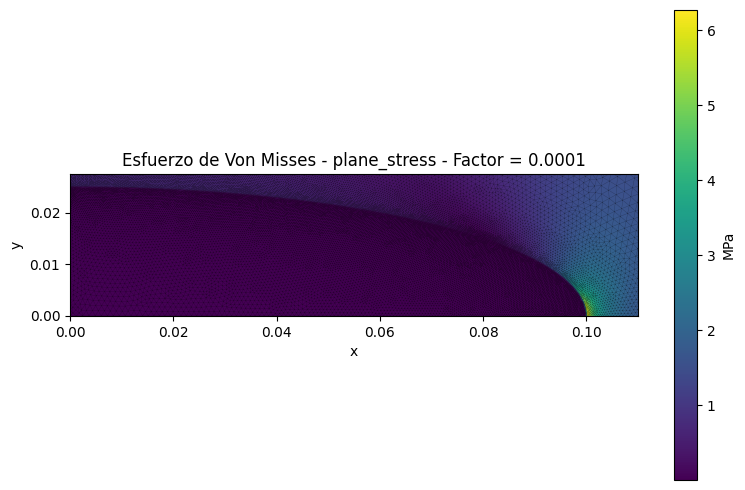

In [17]:
plate.plot_von_misses(ellipse_zoom=True)

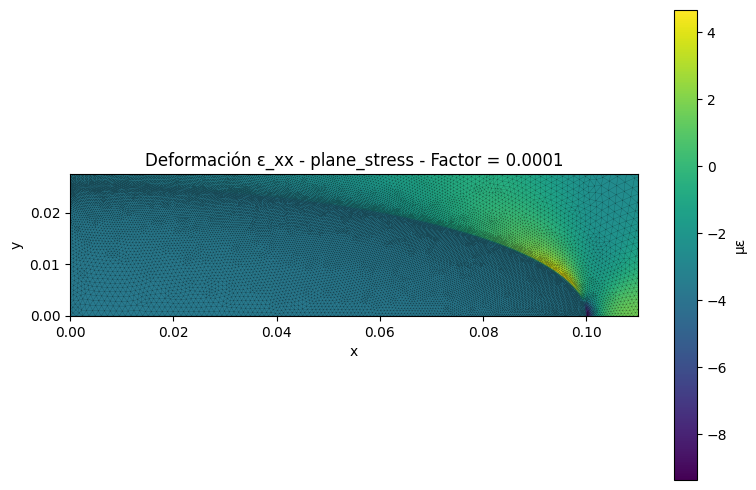

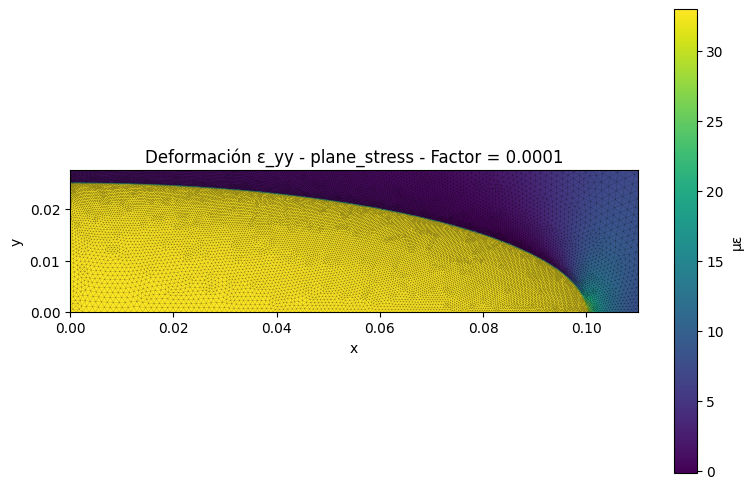

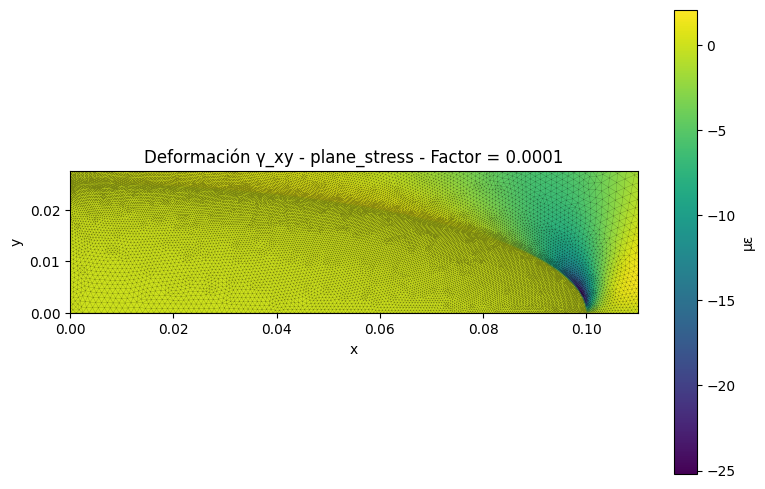

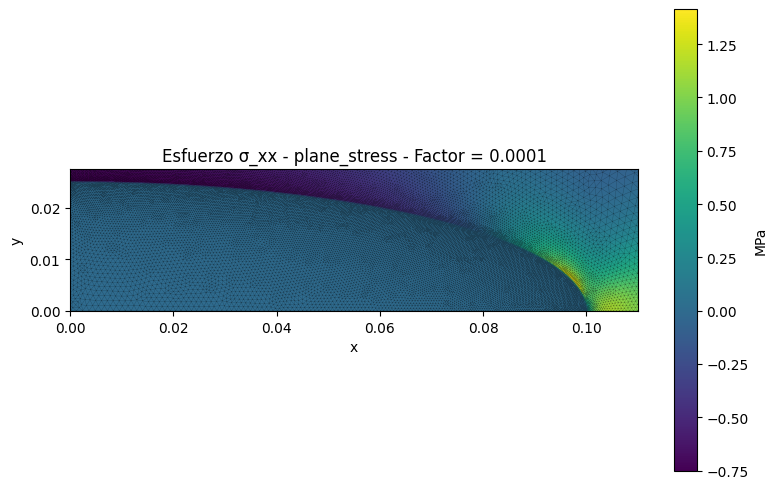

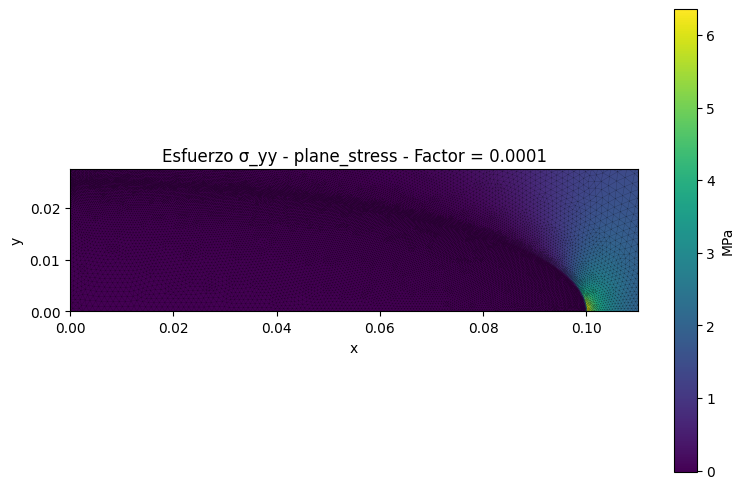

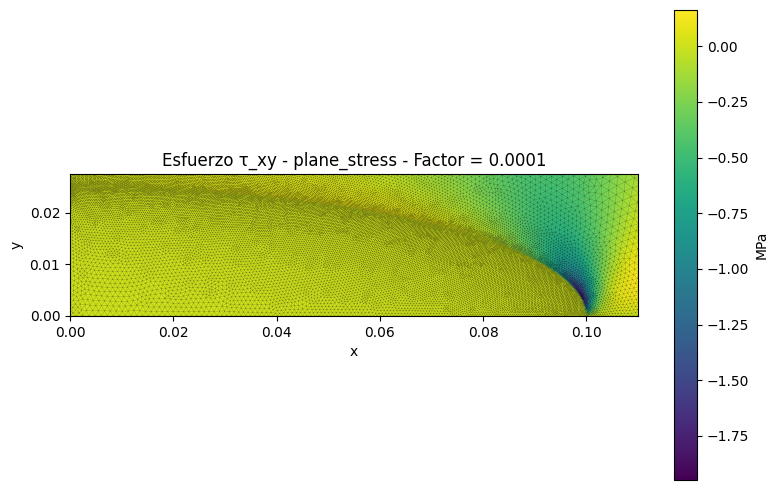

In [18]:
  plate.plot_strain_stress(ellipse_zoom=True)

In [98]:
import numpy as np

def dundurs_params(E1, nu1, E2, nu2, mode="plane_stress"):
    mu1 = E1 / (2*(1 + nu1))
    mu2 = E2 / (2*(1 + nu2))

    if mode == "plane_strain":
        k1 = 3 - 4*nu1
        k2 = 3 - 4*nu2
    elif mode == "plane_stress":
        k1 = (3 - nu1) / (1 + nu1)
        k2 = (3 - nu2) / (1 + nu2)
    else:
        raise ValueError("mode debe ser 'plane_strain' o 'plane_stress'")

    # Eqs. (54) del paper
    alpha = (mu2*(k1 + 1) - mu1*(k2 + 1)) / (mu2*(k1 + 1) + mu1*(k2 + 1))
    beta  = (mu2*(k1 - 1) - mu1*(k2 - 1)) / (mu2*(k1 + 1) + mu1*(k2 + 1))

    return alpha, beta, k1, k2, mu1, mu2


def analytic_inclusion_stress(E1, nu1, E2, nu2,
                              a, b,
                              sigma0_x=0.0, sigma0_y=0.0, tau0_xy=0.0,
                              mode="plane_stress"):

    t = b / a
    alpha, beta, k1, k2, mu1, mu2 = dundurs_params(E1, nu1, E2, nu2, mode=mode)
    print(alpha)
    print(beta)
    fxx = (1+t)**2 * (1+alpha) + 2*t*(t*alpha*beta)
    fxy = 2*(alpha - 2*beta - t*beta)
    fyx = 2*t*(t*alpha - beta - 2*t*beta)
    fyy = -(1+t)**2 * (1 + alpha) + 2*(t*beta + alpha)

    f = np.array([[fxx, fxy],
                  [fyx, fyy]])
    sigma0 = np.array([sigma0_x, sigma0_y]).reshape((2,1))

    delta = (alpha**2 - 1)*(1 - t)**2 + 4*t*(beta + 1)*(2*beta-alpha-1)

    stress_analytical = (1+alpha)*(1/delta)*(f @ sigma0)

    return stress_analytical[0][0], stress_analytical[1][0], 0

def compare_inclusion_stress(sys,
                             E_m, nu_m,
                             E_i, nu_i,
                             a, b,
                             center=(0.0, 0.0),
                             sigma0_x=0.0, sigma0_y=0.0, tau0_xy=0.0,
                             mode="plane_stress"):

    x0, y0 = center

    # --- 1. Seleccionar nodos dentro de la elipse ---
    x = sys.nodes[:, 0] - x0
    y = sys.nodes[:, 1] - y0

    # elipse: (x/a)^2 + (y/b)^2 < 1
    inside = (x/a)**2 + (y/b)**2 < 1.0
    if not np.any(inside):
        raise RuntimeError("No se encontraron nodos dentro de la elipse con los parámetros dados.")

    fem_mean = sys.stress_nodes[inside].mean(axis=0)  # [σxx, σyy, τxy]

    # --- 2. Solución analítica interior ---
    sigma_x_a, sigma_y_a, tau_xy_a = analytic_inclusion_stress(
        E_m, nu_m, E_i, nu_i,
        a, b,
        sigma0_x=sigma0_x,
        sigma0_y=sigma0_y,
        tau0_xy=tau0_xy,
        mode=mode
    )

    # --- 3. Imprimir comparación ---
    print("\n=== Comparación FEM vs analítico (interior de la inclusión) ===")
    print("Esfuerzos medios FEM (Pa):")
    print(f"  σ_xx^FEM = {fem_mean[0]: .6e}")
    print(f"  σ_yy^FEM = {fem_mean[1]: .6e}")
    print(f"  τ_xy^FEM = {fem_mean[2]: .6e}")

    print("\nEsfuerzos analíticos Jin et al. 2014 (Pa):")
    print(f"  σ_xx^ANA = {sigma_x_a: .6e}")
    print(f"  σ_yy^ANA = {sigma_y_a: .6e}")
    print(f"  τ_xy^ANA = {tau_xy_a: .6e}")

    print("\nErrores relativos FEM vs analítico:")
    for name, fem, ana in zip(
        ["σ_xx", "σ_yy", "τ_xy"],
        fem_mean,
        [sigma_x_a, sigma_y_a, tau_xy_a]
    ):
        if abs(ana) < 1e-12:
            print(f"  {name}: ana≈0 → error relativo no definido (usa error absoluto).")
        else:
            err_rel = (fem - ana) / ana * 100.0
            print(f"  {name}: {err_rel: .3f} %")

    return fem_mean, np.array([sigma_x_a, sigma_y_a, tau_xy_a])

def stress_concentration_factor_analytical(
                             E_m, nu_m,
                             E_i, nu_i,
                             a, b,
                             mode="plane_stress"):

  t = b/a
  alpha, beta, k1, k2, mu1, mu2 = dundurs_params(E_m, nu_m, E_i, nu_i, mode=mode)

  delta = (alpha**2 - 1)*(1 - t)**2 + 4*t*(beta + 1)*(2*beta-alpha-1)

  k_ay = (alpha**2 - 1)*(1 + t)**2 + (6*t + 16)*beta*(beta-alpha) + 2*alpha*(alpha+1) + 2*t*beta*(beta+1)

  K_ana = k_ay / delta

  return K_ana

def compare_stress_concentration_factor(sys,
                             E_m, nu_m,
                             E_i, nu_i,
                             a, b,
                             center=(0.0, 0.0),
                             sigma0_x=0.0, sigma0_y=0.0, tau0_xy=0.0,
                             mode="plane_stress"):

  index = np.where((sys.nodes == np.array([a, 0, 0])).all(axis=1))[0][0] # indice del nodo (a,0)
  K_fem_1 = sys.stress_nodes[index,1] / sigma0_y # Factor basado en el nodo (a,0)
  K_fem_2 = sys.stress_nodes[:,1].max() / sigma0_y # Factor basado en el esf máximo, en caso que no este en (a,0)

  K_ana = stress_concentration_factor_analytical(
                             E_m, nu_m,
                             E_i, nu_i,
                             a, b,
                             mode="plane_stress")

  print("\n=== Comparación FEM vs analítico (Concentración de esfuerzos en (a, 0)) ===")
  print("Concentración generada en FEM:")
  #print(f"  K_t1^FEM = {K_fem_1: .6e}")
  print(f"  K_t^FEM = {K_fem_2: .6e}")

  print("\nConcentración analítica esperada")
  print(f"  K_t^ANA = {K_ana: .6e}")

  print("\nErrores relativos FEM vs analítico:")
  for name, fem, ana in zip(
        ["K_t"],
        [ K_fem_2],
        [K_ana]
                           ):
    if abs(ana) < 1e-12:
      print(f"  {name}: ana≈0 → error relativo no definido (usa error absoluto).")
    else:
      err_rel = (fem - ana) / ana * 100.0
      print(f"  {name}: {err_rel: .3f} %")



In [97]:
fem, ana = compare_inclusion_stress(
    plate,
    E_m=206e9,  nu_m=1/3,
    E_i=206e9*plate.factor, nu_i=1/3,
    a=0.1,  b=0.025,
    center=(0.0, 0.0),
    sigma0_x=0.0,
    sigma0_y=1.5e6,
    tau0_xy=0.0,
    mode="plane_stress"
)


-0.9998000199980002
-0.33326667333266674

=== Comparación FEM vs analítico (interior de la inclusión) ===
Esfuerzos medios FEM (Pa):
  σ_xx^FEM = -1.133765e+03
  σ_yy^FEM =  7.231520e+02
  τ_xy^FEM =  8.053323e+01

Esfuerzos analíticos Jin et al. 2014 (Pa):
  σ_xx^ANA =  3.371607e+02
  σ_yy^ANA =  1.461240e+03
  τ_xy^ANA =  0.000000e+00

Errores relativos FEM vs analítico:
  σ_xx: -436.268 %
  σ_yy: -50.511 %
  τ_xy: ana≈0 → error relativo no definido (usa error absoluto).


In [99]:
compare_stress_concentration_factor(plate, E_m=206e9,  nu_m=1/3,
    E_i=206e9*plate.factor, nu_i=1/3,
    a=0.1,  b=0.025,
    center=(0.0, 0.0),
    sigma0_x=0.0,
    sigma0_y=1.5e6,
    tau0_xy=0.0,
    mode="plane_stress"
)


=== Comparación FEM vs analítico (Concentración de esfuerzos en (a, 0)) ===
Concentración generada en FEM:
  K_t^FEM =  4.236046e+00

Concentración analítica esperada
  K_t^ANA =  8.992431e+00

Errores relativos FEM vs analítico:
  K_t: -52.893 %


In [76]:
a = 0.1
b = 0.025
x = plate.nodes[:,0]
y = plate.nodes[:,1]
inside = (x/a)**2 + (y/b)**2 < 1.0

In [77]:
len(plate.nodes[inside])

13408